# TensorFlow Tutorial #03-C
# Keras API

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

Tutorial #02 showed how to implement a Convolutional Neural Network in TensorFlow. We made a few helper-functions for creating the layers in the network. It is essential to have a good high-level API because it makes it much easier to implement complex models, and it lowers the risk of errors.

There are several of these builder API's available for TensorFlow: PrettyTensor (Tutorial #03), Layers API (Tutorial #03-B), and several others. But they were never really finished and now they seem to be more or less abandoned by their developers.

This tutorial is about the Keras API which is already highly developed with very good documentation - and the development continues. It seems likely that Keras will be the standard API for TensorFlow in the future so it is recommended that you use it instead of the other APIs.

The author of Keras has written a [blog-post](https://blog.keras.io/user-experience-design-for-apis.html) on his API design philosophy which you should read.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. See Tutorial #02 for a more detailed description of convolution.

There are two convolutional layers, each followed by a down-sampling using max-pooling (not shown in this flowchart). Then there are two fully-connected layers ending in a softmax-classifier.

![Flowchart](images/02_network_flowchart.png)

## Imports

In [1]:
# 1st learning
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

We need to import several things from Keras.

In [2]:
# 1st learning
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [3]:
# 1st learning
tf.__version__

'2.10.0'

In [3]:
tf.__version__

'2.1.0'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [4]:
# 1st learning
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

In [4]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

The MNIST data-set has now been loaded and consists of 70.000 images and class-numbers for the images. The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [5]:
# 1st learning
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


Copy some of the data-dimensions for convenience.

In [6]:
# 1st learning
img_size = data.img_size

img_size_flat = data.img_size_flat

img_shape = data.img_shape

img_shape_full = data.img_shape_full

num_classes = data.num_classes

num_channels = data.num_channels


In [6]:
# The number of pixels in each dimension of an image.
img_size = data.img_size

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = data.img_shape_full

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = data.num_channels

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [7]:
# 1st learning
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9 # assert 宣称
               
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary') # imshow 即时显示；这部分要去确认 axe 的使用指南
        
        # 呈现真实与预测的类别
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i]) 
            # 大括號及其內的字元（稱為格式欄位）會被取代為傳遞給 str.format() method 的物件。
            # 大括號中的數字表示該物件在傳遞給 str.format() method 時所在的位置。
            # print('{0} and {1}'.format('spam', 'eggs'))
            # spam and eggs
            # print('{1} and {0}'.format('spam', 'eggs'))
            # eggs and spam
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
            
        # 呈现 x 轴上的类别
        ax.set_xlabel(xlabel)
        
        # 移除 ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # 确保图像是在同样一个 cell 里头绘制完成
    plt.show()
        

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

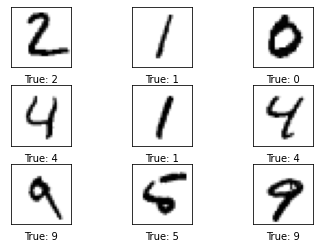

In [8]:
# 1st learning
# 绘制测试

images = data.x_test[1:10]

cls_true = data.y_test_cls[1:10]

# 用我们刚刚建立完成的函数做绘制测试
plot_images(images=images, cls_true=cls_true)

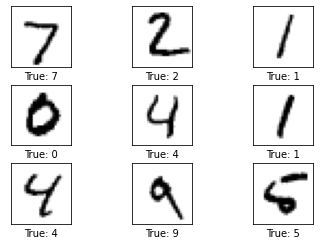

In [8]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [9]:
# 1st learning
def plot_example_errors(cls_pred):
    
    incorrect = (cls_pred != data.y_test_cls) # 问题是，是指哪一个 cls_pred 不等于data.y_test_cls ？）
    
    images = data.x_test[incorrect] # 中括号里头可以包含条件式？
    
    cls_pred = cls_pred[incorrect]
    
    cls_true = data.y_test_cls[incorrect]
    
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
            

In [9]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.y_test_cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## PrettyTensor API

This is how the Convolutional Neural Network was implemented in Tutorial #03 using the PrettyTensor API. It is shown here for easy comparison to the Keras implementation below.

In [10]:
# 1st learning
if False:
    x_pretty = pt.wrap(x_image)
    
    with pt.defaults_scope(activation_fn=tf.nn.relu):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=16, name='layer_conv1').\
            max_pool(kernel=2, stride=2.\
            conv2d(kernel=5, depth=36, name='layer_conv2').\
            max_pool(kernel=2,stride=2).\
            flatten().\
            fully_connected(size=128, name='layer_fc1').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

In [10]:
if False:
    x_pretty = pt.wrap(x_image)

    with pt.defaults_scope(activation_fn=tf.nn.relu):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=16, name='layer_conv1').\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=36, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=128, name='layer_fc1').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

## Sequential Model

The Keras API has two modes of constructing Neural Networks. The simplest is the Sequential Model which **only** allows for the layers to **be added** in sequence.

In [10]:
# 1st learning
# 开始建构顺序模型
# 官方文档网址： https://keras.io/zh/getting-started/sequential-model-guide/
model = Sequential()

# 新增一个输入层，注意它的 shape 必须是 tuple 形式（注意圆括号末尾的逗号,），且包含 image-size
model.add(InputLayer(input_shape=(img_size_flat,)))

# 这个输入是 flattern 过的矩阵，包含 784 个元素
# 但是，conv layer 需要 images 为形状 (28, 28, 1）
model.add(Reshape(img_shape_full)) # 怎么确定直接 reshape 后是我们要的形状？

# 第一个 conv layer，用了 Relu 和 max-pooling
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1')) # 务必去看 Sequenial 的官方文档！！！
model.add(MaxPooling2D(pool_size=2, strides=2)) # stride 迈步前进
# 2023/01/25，共计时 36 分钟。

# 第二个 conv layer 依然用了 Relu 和 max-pooling
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2)) # 为什么每一层要设定 Max pooling 呢？

# 摊平 conv layer 的阶层输出
# 从 4 阶摊平成 2 阶，以作为 FC / dense layer 的输入
model.add(Flatten())

# 第一个 FC/dense layer (含 Relu_activation)
model.add(Dense(128, activation='relu'))

# 最后一个 FC/ dense layer （含 softmax-activation)
model.add(Dense(num_classes, activation='softmax')) # 为什么最后选择了 softmax 呢？

In [11]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array with 784 elements,
# but the convolutional layers expect images with shape (28, 28, 1)
model.add(Reshape(img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu'))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax'))

### Model Compilation

The Neural Network has now been defined and must be finalized by adding a **loss-function, optimizer and performance metrics** (这里有一点像是笑来老师在《教练的真相》里头第四节课提到的管理工作的精髓：布置、监督、验收，而成为一个闭环；以我自己的话来说就是：抓出做得差的、优化它、再评估）. This is called model "compilation" in Keras.

We can either define the optimizer using a string, or if we want more control of its parameters then we need to instantiate (实例化） an object. For example, we can set the learning-rate.

### 模型编译
神经网络已经被定义好，但还需要增加损失函数，优化器和评价指标才能算完成，这被称为Keras的模型“编译(compilation)”。

**我们可以利用字符串来定义优化器**，或者如果我们想要对其参数进行更多的控制那么我们需要实例化一个对象。比如说，我们可以设置学习率。

In [11]:
# 1st learning
# from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.optimizer_v2 import adam as adam_v2
# 上面这两句会报错。

# 后来上网查询才发现，若遇到 TypeError: 'module' object is not callable 
# 的问题时候，把 from xxx import yyy 改成
# import xxx as zzz
# 然后在编码中用 xxx.yyy() 做使用就可以了，下面是实际应用解决

import tensorflow.python.keras.optimizers as op

# optimizer = op.Adam(lr=1e-3)
# 错误警告： The `lr` argument is deprecated, use `learning_rate` instead.
# 因此，将lr 改成 learning_rate 就可以了！ （自己找到方式解决的感觉真好！）
optimizer = op.adam_v2.Adam(learning_rate=1e-3)

In [12]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

For a classification-problem such as MNIST which has 10 possible classes, we need to use the loss-function called `categorical_crossentropy`. The performance metric we are interested in is the classification accuracy.

对于像MNIST这样有10个可能的类别的分类问题，我们需要用到 `categorical_crossentropy`损失函数。我们感兴趣的性能指标（metric）是分类精度。

In [12]:
# 1st learning
# 注意，我上面并没有设定这三项 keras 的 compilation，这里的参数应为内建的！
# 注意，metrics 设定有用中括号
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

Now that the model has been fully defined with loss-function and optimizer, we can train it. This function takes numpy-arrays and performs the given number of training epochs using the given batch-size. An epoch is one full use of the entire training-set. So for 10 epochs we would iterate randomly over the entire training-set 10 times.

In [13]:
# 1st learning
# fit 应为keras内建函数
model.fit(x=data.x_train,
          y=data.y_train,
          epochs=1, batch_size=128)

430/430 [==============================] - 38s 85ms/step - loss: 0.2219 - accuracy: 0.9354


In [14]:
#model.fit(x=data.x_train,
#          y=data.y_train,
#          epochs=1, batch_size=128)

Train on 55000 samples
55000/55000 [==============================] - 21s 375us/sample - loss: 0.2251 - accuracy: 0.9335


### Evaluation

Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [14]:
# 1st learning
# evaluate 为keras内建函数
result = model.evaluate(x=data.x_test,
                        y=data.y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.0665 - accuracy: 0.9779


In [15]:
#result = model.evaluate(x=data.x_test,
#                        y=data.y_test)

10000/10000 [==============================] - 2s 187us/sample - loss: 0.0771 - accuracy: 0.9756


We can print all the performance metrics for the test-set.

下方使用到的 zip 函数，这个[网站](https://ithelp.ithome.com.tw/articles/10218029)有相当好的说明

In [21]:
# 1st learning
# 以下為 zip 函数的练习

dogs = ["阿奇", "毛毛", "天天", "小隶", "灰灰"]
skills = ["警探", "消防", "空中救援", "工程", "回收"]

team_members = list(zip(dogs, skills))
print(team_members)
reverse_team = list(zip(*team_members))
print(reverse_team)
list_team = list(map(list, zip(dogs, skills)))
print(list_team)

# list(map(list,(zip(*A)))) #行列互換，再利用map函數將zip內的元組轉列表

[('阿奇', '警探'), ('毛毛', '消防'), ('天天', '空中救援'), ('小隶', '工程'), ('灰灰', '回收')]
[('阿奇', '毛毛', '天天', '小隶', '灰灰'), ('警探', '消防', '空中救援', '工程', '回收')]
[['阿奇', '警探'], ['毛毛', '消防'], ['天天', '空中救援'], ['小隶', '工程'], ['灰灰', '回收']]


In [23]:
# 1st learning
# 实用的 zip 函数讲解 https://ithelp.ithome.com.tw/articles/10218029
for name, value in zip(model.metrics_names, result): # 用 zip 函数“缝”起来呈现
    print(name, value)

loss 0.06645167618989944
accuracy 0.9779000282287598


In [16]:
#for name, value in zip(model.metrics_names, result):
#    print(name, value)

loss 0.07707656768076122
accuracy 0.9756


Or we can just print the classification accuracy.

In [24]:
# 1st learning
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1])) # 后面的 .2% 推测是指定精度达到小数点第二位
# ：% 表示用百分位表达，.2 则为小数后两位，且预设为四舍五入。
# 上方可参照此网站 https://ithelp.ithome.com.tw/articles/10268066
# 2023/03/07，共计时 56 分钟。

accuracy: 97.79%


In [17]:
#print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

accuracy: 97.56%


### Prediction

We can also predict the classification for new images. We will just use some images from the test-set but you could load your own images into numpy arrays and use those instead.

In [25]:
# 1st learning
images = data.x_test[0:9]
# 2023/02/24

In [18]:
#images = data.x_test[0:9]

These are the true class-number for those images. This is only used when plotting the images.

In [26]:
# 1st learning
cls_true = data.y_test_cls[0:9]

In [19]:
#cls_true = data.y_test_cls[0:9]

Get the predicted classes as One-Hot encoded arrays.

In [27]:
# 1st learning
y_pred = model.predict(x=images)

In [20]:
#y_pred = model.predict(x=images)

Get the predicted classes as integers.

In [28]:
# 1st learning
cls_pred = np.argmax(y_pred, axis=1)

In [21]:
#cls_pred = np.argmax(y_pred, axis=1)

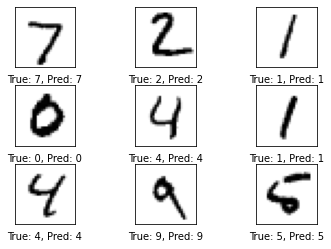

In [29]:
# 1st learning
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

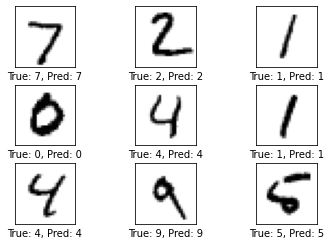

In [22]:
#plot_images(images=images,
#            cls_true=cls_true,
#            cls_pred=cls_pred)

### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:
(先把所有的影像对应上一个预测值)

In [31]:
# 1st learning
y_pred = model.predict(x=data.x_test)

In [23]:
#y_pred = model.predict(x=data.x_test)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers(整数).

In [34]:
# 1st learning
cls_pred = np.argmax(y_pred, axis=1) # 之后要确认 np 里头的 argmax 有着什么样的设定参数
# 在这里意外发现可以快速在每行的前面加上 # 号的方法：Ctrl + ?

In [24]:
#cls_pred = np.argmax(y_pred, axis=1)

Plot some of the mis-classified images.

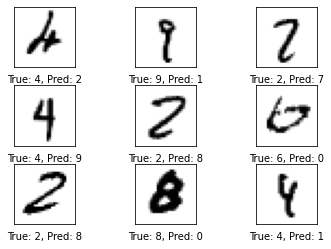

In [35]:
# 1st learning
plot_example_errors(cls_pred)

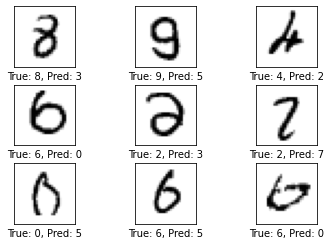

In [25]:
# plot_example_errors(cls_pred)

## Functional Model （更复杂）

The Keras API can also be used to construct more complicated networks using the Functional Model. This may look a little confusing at first, because each call to the Keras API will create and return an instance that is itself callable. It is not clear whether it is a function or an object - but we can call it as if it is a function. This allows us to build computational graphs that are more complex than the Sequential Model allows.

In [39]:
# 1st learning
# 创造一个输入层 （似 TF里头的 feed_dict）
# 注意，输入层的形状必须用 tuple，里头包含有 image_size

inputs = Input(shape=(img_size_flat,)) # 注意 img_size_flat 后方的逗号

# 要用来建造神经网络的变数

net = inputs

# input 是一个被摊平的矩阵，包含有 784 个元素
# 但是 conv layer 希望的输入（图像）形状是 (28, 28, 1）
net = Reshape(img_shape_full)(net) # 嗯？这里怎么又重新用上了 net，是因为会照顺序更新 net 吗？

# 一样，指定出 1st conv layer （包含 Relu_activation 与 max-pooling）
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# 一样，指定出 2nd conv layer
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# 摊平，从 4 转换成 2
net = Flatten()(net) # 注意，自己很容易把 Flatten 写成 Flattern！

# 1st FC/ dense layer with ReLU activation
net = Dense(128, activation='relu')(net)

# 最后的 FC/ dense layer with softmax activation，以作为分类
net = Dense(num_classes, activation='softmax')(net)

# 该神经网络 net 的输出
outputs = net

# 到此步为止，基本架构已经完成了，接下来就是需要训练的时候

In [26]:
# Create an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
inputs = Input(shape=(img_size_flat,))

# Variable used for building the Neural Network.
net = inputs

# The input is an image as a flattened array with 784 elements.
# But the convolutional layers expect images with shape (28, 28, 1)
net = Reshape(img_shape_full)(net)

# First convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Second convolutional layer with ReLU-activation and max-pooling.
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

# Flatten the output of the conv-layer from 4-dim to 2-dim.
net = Flatten()(net)

# First fully-connected / dense layer with ReLU-activation.
net = Dense(128, activation='relu')(net)

# Last fully-connected / dense layer with softmax-activation
# so it can be used for classification.
net = Dense(num_classes, activation='softmax')(net)

# Output of the Neural Network.
outputs = net

### Model Compilation

We have now defined the architecture of the model with its input and output. We now have to create a Keras model and compile it with a loss-function and optimizer, so it is ready for training.

In [40]:
# 1st learning
from tensorflow.python.keras.models import Model

In [27]:
# from tensorflow.python.keras.models import Model

Create a new instance of the Keras Functional Model. We give it the inputs and outputs of the Convolutional Neural Network that we constructed above.

In [41]:
# 1st learning
model2 = Model(inputs=inputs, outputs=outputs)

In [28]:
# model2 = Model(inputs=inputs, outputs=outputs)

Compile the Keras model using the **RMSprop optimizer** and with a loss-function for multiple categories. The only performance metric we are interested in is the classification accuracy, but you could use a list of metrics here.

In [44]:
# 1st learning
# 对了，还要加上优化器、损失函数、以及正确率评估
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [29]:
# model2.compile(optimizer='rmsprop',
               # loss='categorical_crossentropy',
               # metrics=['accuracy'])

### Training

The model has now been defined and compiled so it can be trained using the same `fit()` function as used in the Sequential Model above. This also takes numpy-arrays as input.

In [45]:
# 1st learning
# 开始训练喽！
model2.fit(x=data.x_train,
           y=data.y_train,
           epochs=1, batch_size=128)

430/430 [==============================] - 38s 87ms/step - loss: 0.2037 - accuracy: 0.9366


In [30]:
# model2.fit(x=data.x_train,
           # y=data.y_train,
           # epochs=1, batch_size=128)

Train on 55000 samples
55000/55000 [==============================] - 16s 298us/sample - loss: 0.1977 - accuracy: 0.9389


### Evaluation

Once the model has been trained we can evaluate its performance on the test-set. This is the same syntax as for the Sequential Model.

In [46]:
# 1st learning
# 是的，当训练完成时候，接下来就是评估的时刻
result = model2.evaluate(x=data.x_test,
                         y=data.y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0555 - accuracy: 0.9798


In [31]:
# result = model2.evaluate(x=data.x_test,
                         # y=data.y_test)

10000/10000 [==============================] - 2s 169us/sample - loss: 0.0563 - accuracy: 0.9809


The result is a list of values, containing the loss-value and all the metrics we defined when we compiled the model. Note that 'accuracy' is now called 'acc' which is a small inconsistency.

In [47]:
# 1st learning
# 显示正确率的时候
for name, value in zip(model2.metrics_names, result):
    print(name, value)

loss 0.055507805198431015
accuracy 0.9797999858856201


In [32]:
# for name, value in zip(model2.metrics_names, result):
    # print(name, value)

loss 0.05628199413705152
accuracy 0.9809


We can also print the classification accuracy as a percentage:

In [48]:
# 1st learning
print("{0}: {1:.3%}".format(model2.metrics_names[1], result[1]))

accuracy: 97.980%


In [33]:
# print("{0}: {1:.2%}".format(model2.metrics_names[1], result[1]))

accuracy: 98.09%


### Examples of Mis-Classified Images

We can plot some examples of mis-classified images from the test-set.

First we get the predicted classes for all the images in the test-set:

In [49]:
# 1st learning
y_pred = model2.predict(x=data.x_test)

In [34]:
# y_pred = model2.predict(x=data.x_test)

Then we convert the predicted class-numbers from One-Hot encoded arrays to integers.

* One-Hot encoded，指的是资料预处理的格式，将个别的变数变成一个数值方便做处理。然而，这样的处理后的格式，本身是一段没有意义的数值，对于计算资源的占用会比较大，甚至引发“维度灾难”。可能是基于这样的理由，因此在这里需要再次处理、将其转换。对 One-Hot encoder 可以参考这个[网站](https://ithelp.ithome.com.tw/articles/10272964)。

In [50]:
# 1st learning
cls_pred = np.argmax(y_pred, axis=1)

In [35]:
# cls_pred = np.argmax(y_pred, axis=1)

Plot some of the mis-classified images.

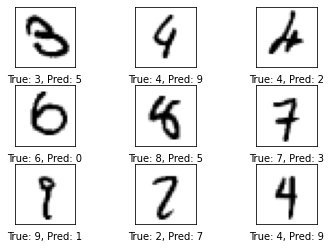

In [51]:
# 1st learning
plot_example_errors(cls_pred)

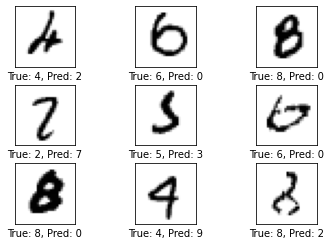

In [36]:
# plot_example_errors(cls_pred)

## Save & Load Model

NOTE: You need to install `h5py` for this to work!

Tutorial #04 was about saving and restoring the weights of a model using native TensorFlow code. It was an absolutely horrible API! Fortunately, Keras makes this very easy.

This is the file-path where we want to save the Keras model.

In [53]:
# %pip install h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
# 1st learning
# 嗯，新东西
path_model = 'model.keras'

In [37]:
# path_model = 'model.keras'

Saving a Keras model with the trained weights is then just a single function call, as it should be.

In [55]:
# 1st learning
model2.save(path_model)

In [38]:
# model2.save(path_model)

Delete the model from memory so we are sure it is no longer used.

In [56]:
# 1st learning
del model2

In [ ]:
# del model2

We need to import this Keras function for loading the model.

In [57]:
# 1st learning
# 先删除，再读档
from tensorflow.python.keras.models import load_model

In [40]:
# from tensorflow.python.keras.models import load_model

Loading the model is then just a single function-call, as it should be.

In [58]:
# 1st learning
# 一样，一个函数就能叫出来我们要的 model
model3 = load_model(path_model)

In [41]:
# model3 = load_model(path_model)

We can then use the model again e.g. to make predictions. We get the first 9 images from the test-set and their true class-numbers.

In [59]:
# 1st learning
# 好的，已经叫出来了先前存档的 model，为了验证这件事，我们再次用 test-set 来试试看
images = data.x_test[0:9]

In [42]:
# images = data.x_test[0:9]

In [60]:
# 1st learning
cls_true = data.y_test_cls[0:9]

In [43]:
# cls_true = data.y_test_cls[0:9]

We then use the restored model to predict the class-numbers for those images.

In [61]:
# 1st learning
# 用上读档的 model 喽
y_pred = model3.predict(x=images) # 用上 predict 函数，里头再指定资料来源是哪里

In [44]:
# y_pred = model3.predict(x=images)

Get the class-numbers as integers.

In [62]:
# 1st learning
# 获取 class-numbers 并且确认是整数的格式
cls_pred = np.argmax(y_pred, axis=1)

In [45]:
# cls_pred = np.argmax(y_pred, axis=1)

Plot the images with their true and predicted class-numbers.

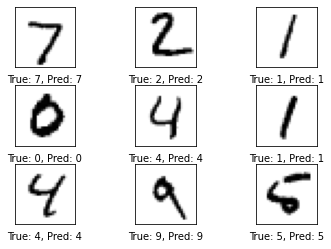

In [63]:
# 1st learning
plot_images(images=images,
            cls_pred=cls_pred,
            cls_true=cls_true)
# 2023/03/14，共计时 82 分钟。

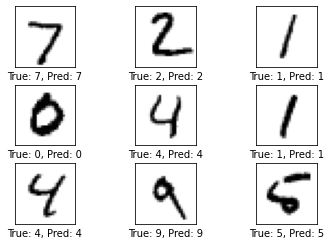

In [46]:
# plot_images(images=images,
            # cls_pred=cls_pred,
            # cls_true=cls_true)

## Visualization of Layer Weights and Outputs

### Helper-function for plotting convolutional weights

In [75]:
# 1st learning
# 再次写好帮助函数，用以绘制出 conv 里头神秘的 weights。

def plot_conv_weights(weights, input_channel=0):
    # 获取最低与最高的加权参数 weights
    # 同时，也要绘制出浅显易懂的，用颜色深浅表示的正确率
    # 好用来比较彼此用。
    w_min = np.min(weights)
    w_max = np.max(weights)
    
    # 指定在 conv layer 的 过滤器数量 （可是却是用 shape?）
    num_filters = weights.shape[3]
    
    # 决定网格的绘制数量
    # 将过滤器的数量用四舍五入（round up）与平方根做处理
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # 绘制一张副图像
    fig, axes = plt.subplots(num_grids, num_grids)
    
    # 绘制出所有的 过滤器 加权 （filter-weights）
    for i, ax in enumerate(axes.flat):
        # 仅绘制出有效的 filter-weights
        if i < num_filters:
            # 获取 input channel 第 i 个位置的 过滤器
            # 查看 new_conv_layer 的过滤器加权细节（4D 格式）
            img = weights[:, :, input_channel, i]
            
            # 绘制即时图像
            ax.imshow(img, vmin=w_min, vmax=w_max, # vmin 与 vmax 究竟是什么意思呢？
                     interpolation='nearest', cmap='seismic') # interpolation，指的是内插，在从应为数学上的内插法
            
        # 从图像上去掉 ticks；注意缩排的距离，后面引用时曾经因为缩排的距离错误导致报错；进一步测试时发现，
        # 其实还有一个错误是 ticks 前面要指定 x 或 y 的 ticks才可以。
        ax.set_xticks([])
        ax.set_yticks([])
    # 确保绘制出的图像是在同一个 cell 里头
    plt.show()

In [47]:
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Get Layers

Keras has a simple way of listing the layers in the model.

In [65]:
# 1st learning
# 作为 TF 应用界面的 keras，在这里展现出了相当方便的一面：一个指令秀出目前已有的层的清单！
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1764)              0     

In [48]:
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0     

We count the indices to get the layers we want.

The input-layer has index 0.

In [66]:
# 1st learning
layer_input = model3.layers[0]

In [49]:
# layer_input = model3.layers[0]

The first convolutional layer has index 2.

In [67]:
# 1st learning
layer_conv1 = model3.layers[2]
layer_conv1

In [50]:
# layer_conv1 = model3.layers[2]
# layer_conv1

The second convolutional layer has index 4.

In [68]:
# 1st learning
layer_conv2 = model3.layers[4]

In [51]:
# layer_conv2 = model3.layers[4]

### Convolutional Weights

Now that we have the layers we can easily get their weights.

In [69]:
# 1st learning
# 获取加权 weights
weights_conv1 = layer_conv1.get_weights()[0]

In [52]:
# weights_conv1 = layer_conv1.get_weights()[0]

This gives us a 4-rank tensor.

In [71]:
# 1st learning
# 展现加权 weights
weights_conv1.shape

(5, 5, 1, 16)

In [53]:
# weights_conv1.shape

(5, 5, 1, 16)

Plot the weights using the helper-function from above.

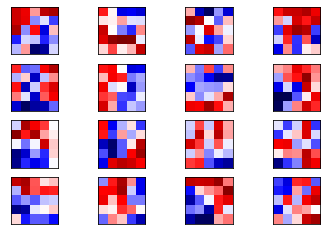

In [76]:
# 1st learning
# 用先前的函数绘制出加权图像
plot_conv_weights(weights=weights_conv1, input_channel=0)

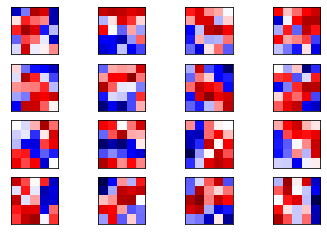

In [54]:
# plot_conv_weights(weights=weights_conv1, input_channel=0)

We can also get the weights for the second convolutional layer and plot them.

In [77]:
# 1st learning
# 获取另外一层的加权
weights_conv2 = layer_conv2.get_weights()[0]

In [55]:
# weights_conv2 = layer_conv2.get_weights()[0]

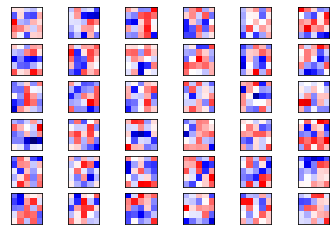

In [78]:
# 1st learning
# 再次绘制
plot_conv_weights(weights=weights_conv2, input_channel=0)

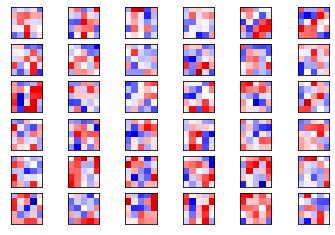

In [56]:
# plot_conv_weights(weights=weights_conv2, input_channel=0)

### Helper-function for plotting the output of a convolutional layer

In [86]:
# 1st learning
# 来写绘制输出 conv layer 的函数了
def plot_conv_output(values):
    # 要用在 conv layer 的 滤过器数量
    num_filters = values.shape[3]
    
    # 需要批量绘制的数量
    # 取滤过器数量的平方根，并且四舍五入
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # 批量创造子图
    fig, axes = plt.subplots(num_grids, num_grids)
    
    # 绘制所有过滤器的输出图像
    for i, ax in enumerate(axes.flat):
        # 只绘制出有效的过滤器图像 # 那什么是无效的过滤器？
        if i<num_filters:
            # 借由第 i 个过滤器取得输出图像
            img = values[0, :, :, i]
            
            # 绘制图像
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # 移除坐标标签
        ax.set_xticks([])
        ax.set_yticks([])
    # 再次确保绘制图像在同一个 cell 里
    plt.show()

In [57]:
def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Image

Helper-function for plotting a single image.

In [81]:
# 1st learning
# 绘制单一图像的帮助函数
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')
    
    plt.show()

In [58]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

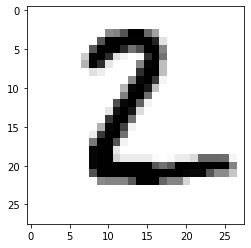

In [82]:
# 1st learning
image1 = data.x_test[1]
plot_image(image1)

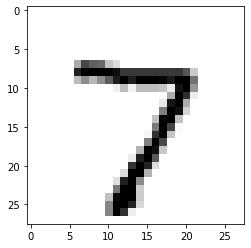

In [59]:
image1 = data.x_test[0]
plot_image(image1)

### Output of Convolutional Layer

In order to show the output of a convolutional layer, we can create another Functional Model using the same input as the original model, but the output is now taken from the convolutional layer that we are interested in.

In [83]:
# 1st learning
# 既然我们可以将conv layer 的输出作为其他层的输入，
# 我们当然也可以将该输出截取出来，作为绘制之用
output_conv2 = Model(inputs=layer_input.input,
                     outputs=layer_conv2.output)

In [60]:
# output_conv2 = Model(inputs=layer_input.input,
                     # outputs=layer_conv2.output)

This creates a new model-object where we can call the typical Keras functions. To get the output of the convoloutional layer we call the `predict()` function with the input image.

In [84]:
# 1st learning
# 为了获取 conv layer 的输出，我们可以使用 predict() 这个函数
layer_output2 = output_conv2.predict(np.array([image1]))
layer_output2.shape

(1, 14, 14, 36)

In [61]:
# layer_output2 = output_conv2.predict(np.array([image1]))
# layer_output2.shape

(1, 14, 14, 36)

We can then plot the images for all 36 channels.

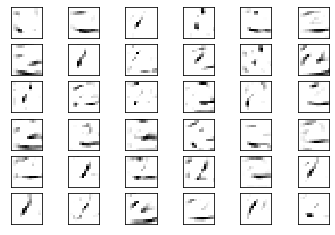

In [87]:
# 1st learning
# 现在我们可以绘制 36 个频道的图像了
plot_conv_output(values=layer_output2)

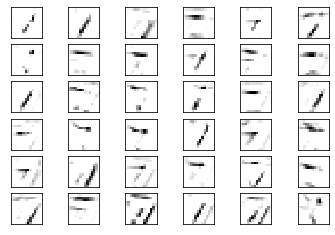

In [62]:
# plot_conv_output(values=layer_output2)

## Conclusion

This tutorial showed how to use the so-called *Keras API* for easily building Convolutional Neural Networks in TensorFlow. Keras is by far the most complete and best designed API for TensorFlow.

This tutorial also showed **how to use Keras to save and load a model**, as well as getting the weights and outputs of convolutional layers.

It seems likely that Keras will be the standard API for TensorFlow in the future, for the simple reason that is already very good and it is constantly being improved. So it is recommended that you use Keras.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience （动手的经验！） with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Train for more epochs. Does it improve the classification accuracy?

用更多的 epochs，看看这样做是否改善了分类的正确率？
* Change the activation function to sigmoid for some of the layers.

换换别的 activation 试试看比如 sigmoid。
* Can you find a simple way of changing the activation function for all the layers?

你有办法找到简单的方式一次调整所有层的 activation 吗？ 
* Plot the output of the max-pooling layers instead of the conv-layers.

试试看绘制 max-pooling layerS 的输出 (2023/03/16，共计时 44 分钟)
* Replace the 2x2 max-pooling layers with stride=2 in the convolutional layers. Is there a difference in classification accuracy? What if you optimize it again and again? The difference is random, so how would you measure if there really is a difference? What are the pros and cons of using max-pooling vs. stride in the conv-layer?

哇，这感觉必须要先备份才能执行啊，不过，虽然有一些难度，但感觉如此动一动参数，看看其中的变化，会是一件有意思且学习加速的事。
* Change the parameters for the layers, e.g. the kernel, depth, size, etc. What is the difference in time usage and classification accuracy?

看起来这里需要进一步去了解不同层的参数代表的细节含义，尤其是参数中包含有的预设值选项们。
* Add and remove some convolutional and fully-connected layers.

这里是建议减少或新增不同的层，看看会有什么变化。让我想起了李骏老师的人工智能课里头说的，这些可以自己调整。
* What is the simplest network you can design that still performs well?

哦？这个任务就更有挑战了，挑战优化的尝试。
* Change the Functional Model so it has another convolutional layer that connects in parallel to the existing conv-layers before going into the dense layers.

这里一时有些不太明白，大概是自己对于 functional model 的组成与含义还不太熟悉的缘故，那就多练习就能了解这个任务了吧。
* Change the Functional Model so it outputs the predicted class both as a One-Hot encoded array and as an integer, so we don't have to use `numpy.argmax()` afterwards.

同上，模模糊糊地知道他说的部分内容，像是把预测输出值试试看用 One-Hot 与整数（非浮点数）的方式设定。但那会产生什么效果呢？自己其实没概念。
* Remake the program yourself without looking too much at this source-code.

啊啊，这个任务很直白，就是不看太多示范而能够自己编写出上面 cell 的内容，比如层的设定、帮助函数的设定等等。我想我可以先从这个任务开始走起。
* Explain to a friend how the program works.

嗯...要找谁呢？不过自己先熟练才具备能力说给人听。

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.